# Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


# Machine Learning Libraries
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import(accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,classification_report,confusion_matrix)



# Loading the Dataset

In [3]:
df = pd.read_csv("Cleaned_Attrition_CSV")
df1 = df.copy()

# Encoding and Feature Extraction

In [4]:
label_encoder = LabelEncoder()

#Mapping categorical columns to numeric values using label encoding
df1['Attrition'] = label_encoder.fit_transform(df1['Attrition'])
df1['Overtime_Working'] = label_encoder.fit_transform(df1['Overtime_Working'])
df1['Gender'] = label_encoder.fit_transform(df1['Gender'])
df1['MaritalStatus'] = label_encoder.fit_transform(df1['MaritalStatus'])
df1['BusinessTravel'] = label_encoder.fit_transform(df1['BusinessTravel'])

#Convert categorical attributes with more than 2 distinct values
df1 = pd.get_dummies(df1, columns = ['Department','EducationField','JobRole'])

#Combine the features into single column
df1['Employee_Satisfaction'] = df1['EnvironmentSatisfaction']+df1['JobSatisfaction']+df1['WorkLifeBalance']
df1['Employee_Rating'] = df1['JobInvolvement']+df1['PerformanceRating']
df1['Employee_risk_rating'] = df1[['Employee_Rating', 'MonthlyIncome',
                                   'Employee_Satisfaction', 'JobLevel', 'StockOptionLevel',
                                    'Education']].apply(lambda x:
                                        0 + (1 if x['MonthlyIncome'] < 30000 else 0) +
                                        (1 if x['Employee_Satisfaction'] <= 3 else 0) +
                                        (1 if x['Education'] == 1 else 0) +
                                        (1 if x['Employee_Rating'] <= 2 else 0) +
                                        (1 if x['JobLevel'] == 1 else 0) +
                                        (1 if x['StockOptionLevel'] == 0 else 0),
                                         axis=1)

#Drop unwanted columns
df1.drop(columns = ['EmployeeID','JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'YearsAtCompany','YearsSinceLastPromotion',
                  'YearsWithCurrManager'],inplace=True)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Holiday_taken                      4410 non-null   int64
 1   Overtime_Working                   4410 non-null   int32
 2   Age                                4410 non-null   int64
 3   Attrition                          4410 non-null   int32
 4   BusinessTravel                     4410 non-null   int32
 5   DistanceFromHome                   4410 non-null   int64
 6   Education                          4410 non-null   int64
 7   Gender                             4410 non-null   int32
 8   JobLevel                           4410 non-null   int64
 9   MaritalStatus                      4410 non-null   int32
 10  MonthlyIncome                      4410 non-null   int64
 11  NumCompaniesWorked                 4410 non-null   int64
 12  PercentSalaryHike   

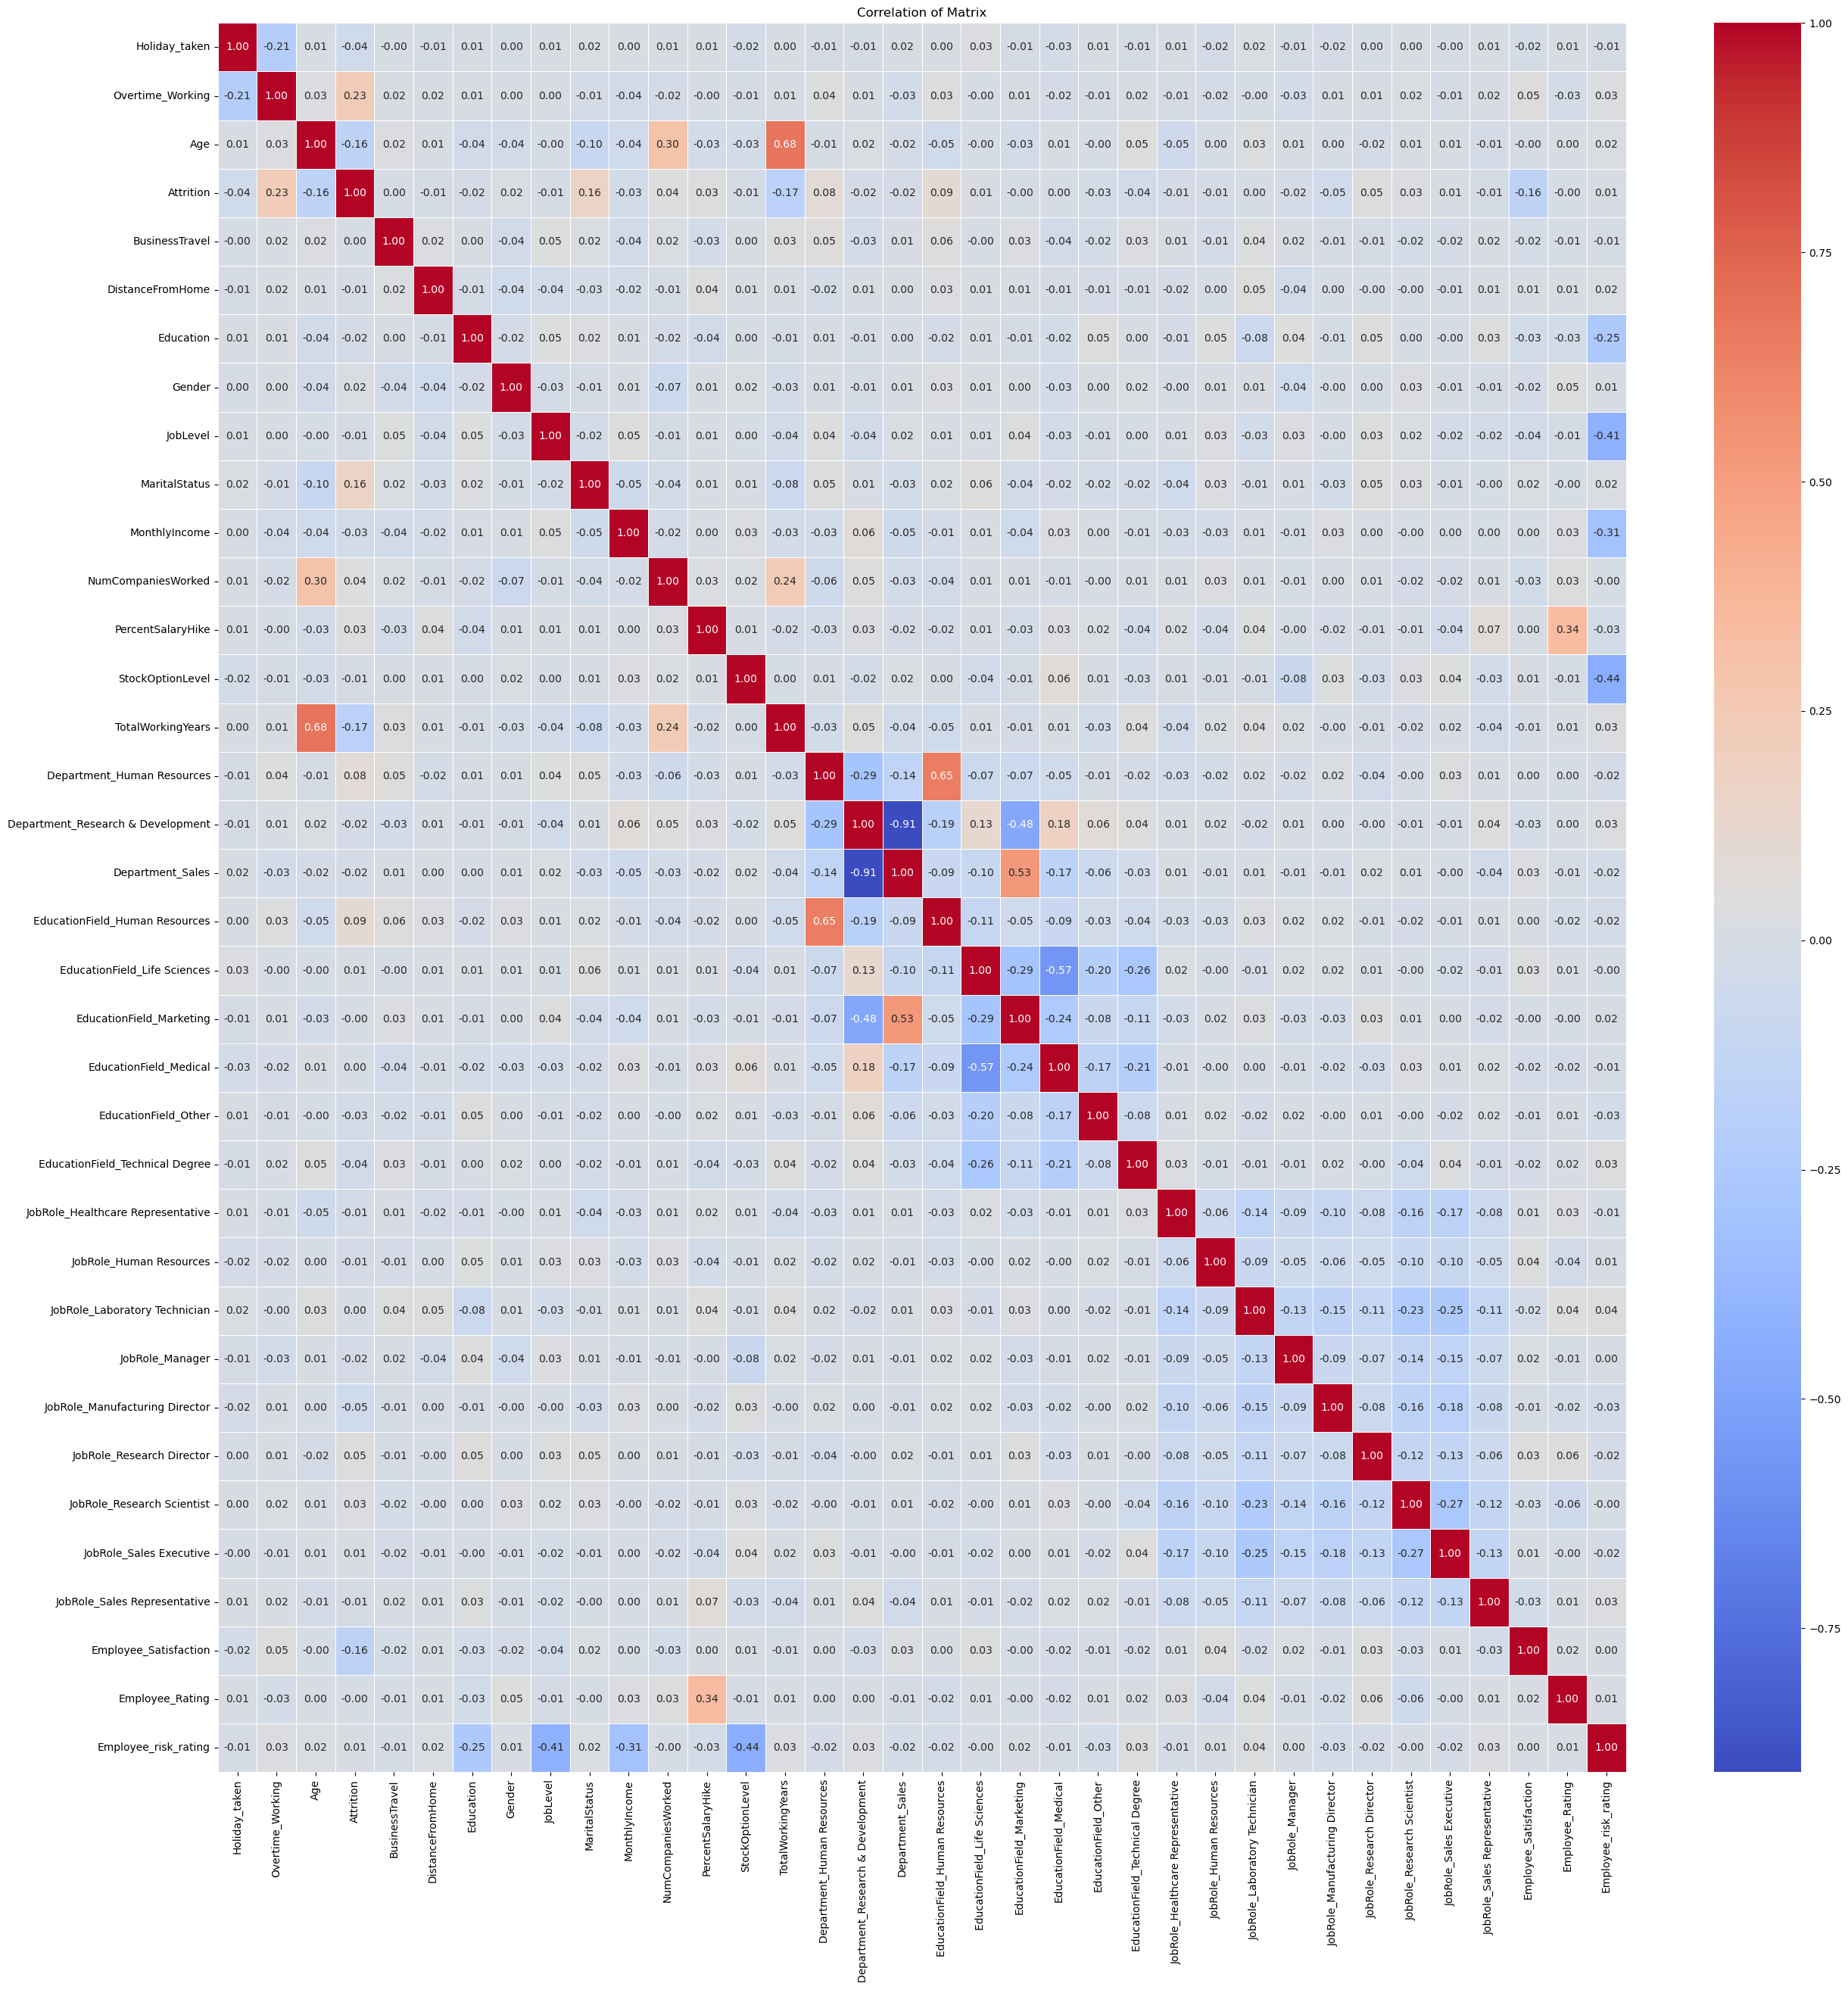

In [6]:
# Correlation Matrix

corr_mat = df1.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr_mat,annot=True,cmap = 'coolwarm', fmt='.2f',linewidths = 0.5)
plt.title("Correlation of Matrix")
plt.show()

In [7]:
# Dropping columns with multicollinearity 
df1.drop(columns = ['EducationField_Human Resources','Department_Sales'],inplace=True)

# Model Building

## 1. Extracting Target and Features

In [8]:
# Target Variable
y = df1['Attrition']
# Features
X = df1.drop(columns='Attrition')

## 2.Data Splitting and Resampling

In [9]:
x_temp,x_test,y_temp,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Again split the temporary into train and validation
x_train,x_val,y_train,y_val = train_test_split(x_temp,y_temp,test_size=0.2,random_state=42,stratify=y_temp)

#Apply SMOTE only for Training data to oversample the minority data
smote = SMOTE(random_state=42)
x_train_smote,y_train_smote = smote.fit_resample(x_train,y_train)

#Apply StandardScaler for Feature Scaling on training data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_smote)
x_val_scaled = scaler.fit_transform(x_val)
x_test_scaled = scaler.fit_transform(x_test)

#List the shapes of each variables
variables = ['x_train_scaled','x_val_scaled','x_test_scaled','y_train_smote','y_val','y_test']
for i in variables:
    var = locals()[i]
    print(f"Shape of {i}:{var.shape}")

Shape of x_train_scaled:(4734, 33)
Shape of x_val_scaled:(706, 33)
Shape of x_test_scaled:(882, 33)
Shape of y_train_smote:(4734,)
Shape of y_val:(706,)
Shape of y_test:(882,)


## Model Evaluation and Comparison

In [18]:
# This is a classification problem so we consider the following classifiers

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42)
}

score = []

#Evaluate each classifier

for name, classifier in classifiers.items():
    # Train the model
    classifier.fit(x_train_smote,y_train_smote)
    
    #Prediction on validation set
    y_val_pred = classifier.predict(x_val)
    y_val_prob = classifier.predict_proba(x_val)[:,1]
    
    #Prediction on test set
    y_test_pred = classifier.predict(x_test)
    
    #Evaluation metrics for validation set
    Accuracy_val = round(accuracy_score(y_val,y_val_pred),4)
    Precision_val = round(precision_score(y_val,y_val_pred),4)
    Recall_val = round(recall_score(y_val,y_val_pred),4)
    F1_Score_val = round(f1_score(y_val,y_val_pred),4)
    ROC_AUC_Score_val = round(roc_auc_score(y_val,y_val_prob),4)
    
    #Evaluation metrics for test set
    Accuracy_test = round(accuracy_score(y_test,y_test_pred),4)
    Precision_test = round(precision_score(y_test,y_test_pred),4)
    Recall_test = round(recall_score(y_test,y_test_pred),4)
    F1_Score_test = round(f1_score(y_test,y_test_pred),4)
    ROC_AUC_Score_test = round(roc_auc_score(y_test,y_test_pred),4)
    
    
 #Update the Scores 
    score.append({
      'Classifier Name' : name,
      'Accuracy_Val ': Accuracy_val,
      'Precision_Val ': Precision_val,
      'Recall_Val' : Recall_val,
      'F1_Score_Val': F1_Score_val,
      'ROC_AUC_Score_Val' : ROC_AUC_Score_val,
      'Accuracy_test' : Accuracy_test,
      'Precision_test' : Precision_test,
      'Recall_test' : Recall_test,
      'F1_Score_test' : F1_Score_test,
      'ROC_AUC_Score_test' : ROC_AUC_Score_test
      })
    print(f"\n{40*'='}\n{name}\n{40*'='}")    
    print("Validation Accuracy : ",Accuracy_val)
    print("Classification Report : \n",classification_report(y_val,y_val_pred))
    print(" Test Accuracy : ",Accuracy_test)
    print("Test Classification Report : \n",classification_report(y_test,y_test_pred))
    
    #Change the list into dataframe
Score_df = pd.DataFrame(score)


Logistic Regression
Validation Accuracy :  0.5992
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.57      0.71       592
           1       0.25      0.73      0.37       114

    accuracy                           0.60       706
   macro avg       0.58      0.65      0.54       706
weighted avg       0.81      0.60      0.65       706

 Test Accuracy :  0.5828
Test Classification Report : 
               precision    recall  f1-score   support

           0       0.88      0.58      0.70       740
           1       0.22      0.61      0.32       142

    accuracy                           0.58       882
   macro avg       0.55      0.59      0.51       882
weighted avg       0.78      0.58      0.64       882


Random Forest
Validation Accuracy :  0.9858
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       592
           1       0.99      0.92

# Comparing Models

In [23]:
Score_df

,Classifier Name,Accuracy_Val,Precision_Val,Recall_Val,F1_Score_Val,ROC_AUC_Score_Val,Accuracy_test,Precision_test,Recall_test,F1_Score_test,ROC_AUC_Score_test
0,Logistic Regression,0.5992,0.2478,0.7281,0.3697,0.7128,0.5828,0.2161,0.6056,0.3185,0.5920
1,Random Forest,0.9858,0.9906,0.9211,0.9545,0.9972,0.9853,0.9850,0.9225,0.9527,0.9599
2,Gradient Boosting,0.8612,0.5597,0.6579,0.6048,0.8782,0.8605,0.5613,0.6127,0.5859,0.7604
3,Support Vector Machine,0.3612,0.1703,0.7632,0.2784,0.4979,0.3639,0.1772,0.8099,0.2908,0.5441
4,DecisionTreeClassifier,0.9249,0.7402,0.8246,0.7801,0.8844,0.9467,0.7950,0.9014,0.8449,0.9284


# Analysis From Above Dataframe

1. Random Forest
    1. Achieves High Accuracy, Precision,Recall and F1 Score on both validation and test sets
    2. The ROC AUC Score is also high give good performance
2. Gradient Boosting
    1. Achieves good Accuracy,Balanced Precision,Recall and F1 Score
    2. High ROC AUC Score
3. Decision Tree Classifier
    1. Good Accuracy,Balanced Precision,Recall and F1 Score
    2. Good ROC AUC Score
    


# In these three models RANDOM FOREST Classifier give 98% of Accuracy so we can go with this model
